In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1282.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Jaguar Gapote 2.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Jaguar Gapote 41.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1295.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1288.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1154.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1207.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1152.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1149.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1255.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1142.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1265.jpg
/kaggle/input/fish-dataset/FishImgDataset/val/Jaguar Gapote/Picture1274.jpg
/ka

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, f1_score


In [3]:
TRAIN_PATH = '/kaggle/input/fish-dataset/FishImgDataset/train'
TEST_PATH = '/kaggle/input/fish-dataset/FishImgDataset/test'
VAL_PATH = '/kaggle/input/fish-dataset/FishImgDataset/val'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


In [4]:
class FishDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = sorted(os.listdir(data_path))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        for cls in self.classes:
            cls_path = os.path.join(data_path, cls)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [5]:
train_dataset = FishDataset(TRAIN_PATH, transform=transform)
val_dataset = FishDataset(VAL_PATH, transform=transform)
test_dataset = FishDataset(TEST_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [6]:
class FishClassificationCNN(nn.Module):
    def __init__(self, num_classes=31):
        super(FishClassificationCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = FishClassificationCNN(num_classes=len(train_dataset.classes))


In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [8]:
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/10
Train Loss: 2.8191, Train Acc: 23.21%
Val Loss: 2.2418, Val Acc: 36.39%

Epoch 2/10
Train Loss: 2.2780, Train Acc: 35.16%
Val Loss: 1.9147, Val Acc: 44.49%

Epoch 3/10
Train Loss: 1.9720, Train Acc: 42.88%
Val Loss: 1.6367, Val Acc: 51.76%

Epoch 4/10
Train Loss: 1.6913, Train Acc: 50.72%
Val Loss: 1.3226, Val Acc: 62.60%

Epoch 5/10
Train Loss: 1.5011, Train Acc: 56.04%
Val Loss: 1.1253, Val Acc: 67.58%

Epoch 6/10
Train Loss: 1.3278, Train Acc: 61.11%
Val Loss: 1.0053, Val Acc: 71.76%

Epoch 7/10
Train Loss: 1.1896, Train Acc: 64.59%
Val Loss: 0.8755, Val Acc: 76.44%

Epoch 8/10
Train Loss: 1.0796, Train Acc: 68.21%
Val Loss: 0.7591, Val Acc: 79.17%

Epoch 9/10
Train Loss: 0.9649, Train Acc: 71.40%
Val Loss: 0.6171, Val Acc: 82.70%

Epoch 10/10
Train Loss: 0.8650, Train Acc: 74.18%
Val Loss: 0.6474, Val Acc: 81.93%



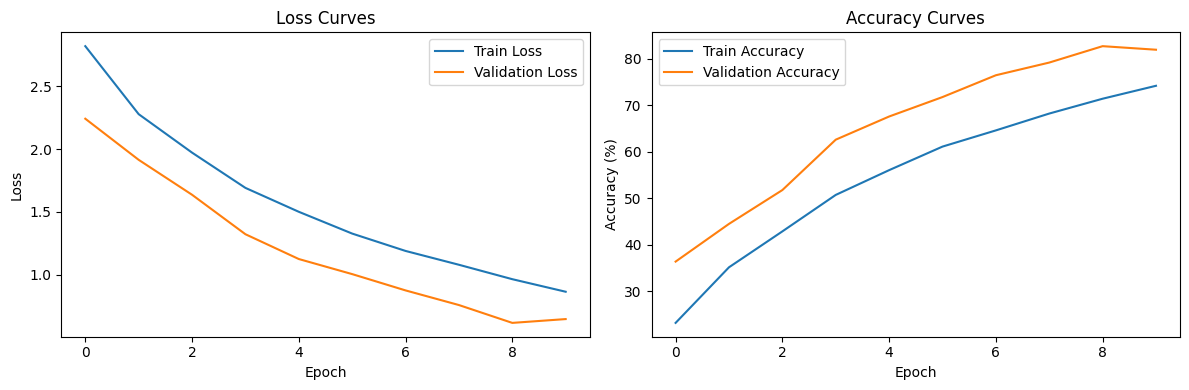

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)


Test Accuracy: 81.26%

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.85      0.65      0.73        34
        Big Head Carp       0.96      0.56      0.71        43
   Black Spotted Barb       0.81      0.55      0.66        40
              Catfish       0.70      0.79      0.74        62
       Climbing Perch       0.81      0.57      0.67        30
 Fourfinger Threadfin       0.78      0.76      0.77        38
       Freshwater Eel       0.72      0.69      0.70        55
       Glass Perchlet       0.93      0.88      0.91        77
                 Goby       0.62      0.88      0.73       124
            Gold Fish       0.80      1.00      0.89        41
              Gourami       0.93      0.86      0.89        63
           Grass Carp       0.92      0.94      0.93       238
 Green Spotted Puffer       0.85      0.77      0.81        22
          Indian Carp       0.96      0.98      0.97        53
  Indo-P

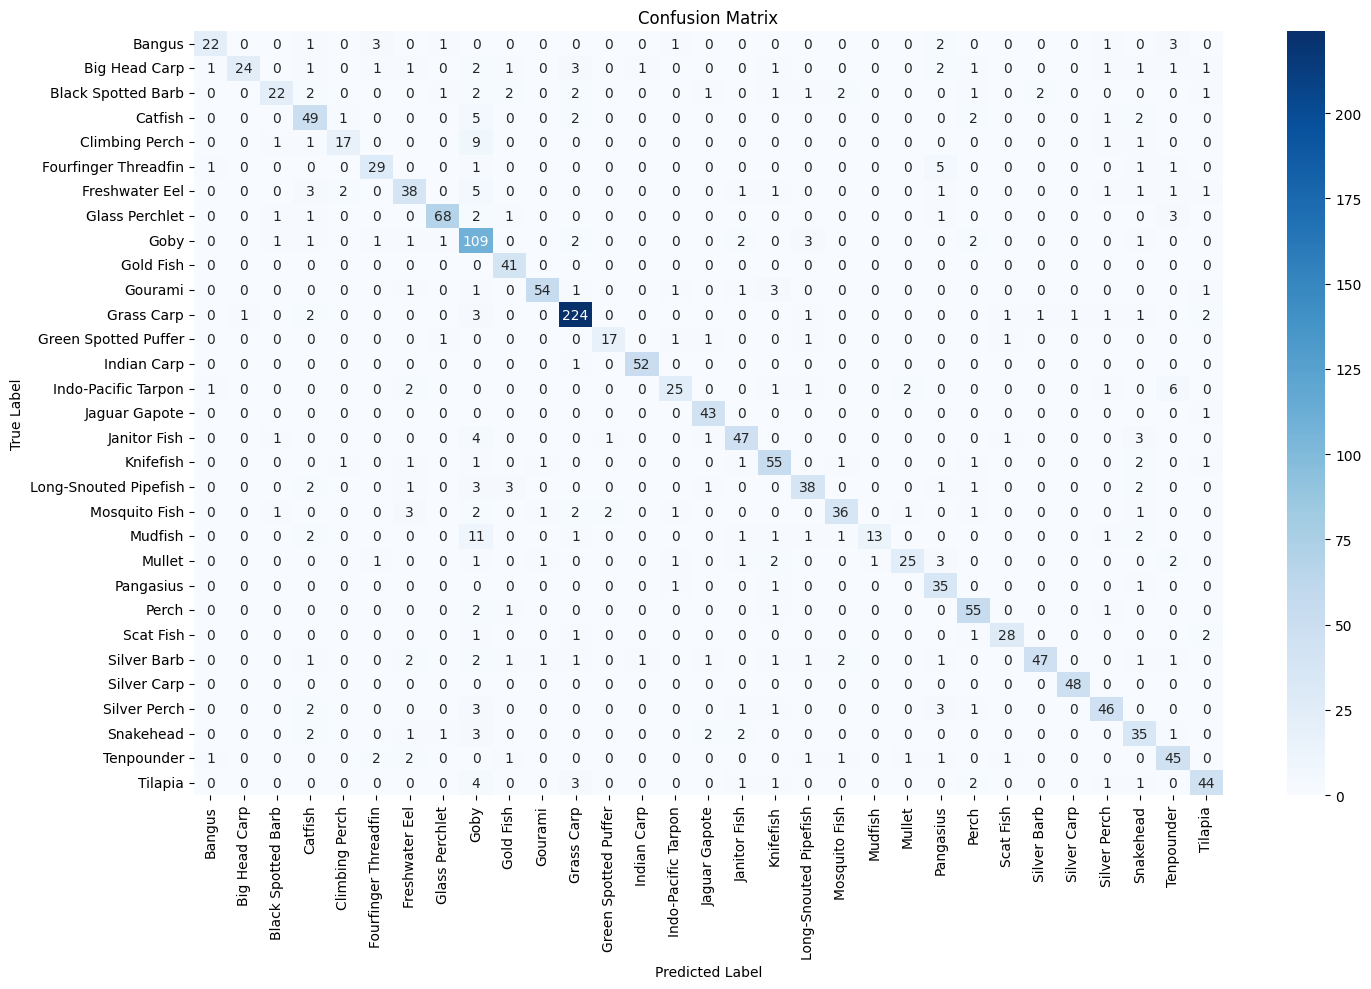

In [13]:
def evaluate_model(model, test_loader, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    y_true, y_pred = [], []
    
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    test_accuracy = 100 * total_correct / total_samples
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\nMacro F1 Score: {f1_macro:.4f}")
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader, train_dataset.classes)


In [14]:
# Path to save the model's state_dict
model_save_path = "CNN_fish.pth"

# Save only the model's state_dict
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to CNN_fish.pth


Predicted Class: Gold Fish


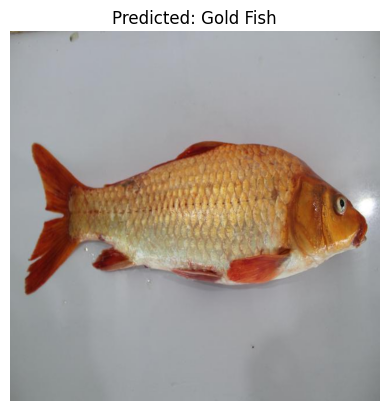

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


model = FishClassificationCNN(num_classes=len(train_dataset.classes))


# model.load_state_dict(torch.load("CNN_fish.pth"))


model.load_state_dict(torch.load("CNN_fish.pth", weights_only=True))



model.eval()



transform_single_image = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def preprocess_image(image_path, transform, device):
    image = Image.open(image_path).convert('RGB')  
    image = transform(image)  
    image = image.unsqueeze(0)  
    return image.to(device)



def predict_image(image_path, model, transform, class_names):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  
    
    with torch.no_grad():
 
        image = preprocess_image(image_path, transform, device)
        
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]
    return predicted_class


uploaded_image_path = "/kaggle/input/fish-dataset/FishImgDataset/test/Gold Fish/CommonCarp_130_jpg.rf.13574f6022ff817f224d787ea9f6c31e.jpg"

predicted_class = predict_image(uploaded_image_path, model, transform_single_image, train_dataset.classes)
print(f"Predicted Class: {predicted_class}")

image = Image.open(uploaded_image_path)
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}")
plt.show()


